# Creating and running the model

We will be creating an OLS regression model based on our data as well as an XGBoost. First we need to import our packages and our file from the first script.

In [34]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns

In [10]:
pbp_games = pd.read_csv("for_model.csv")
pbp_games = pbp_games.dropna(subset=['sum_epa', 'yards', 'is_sunny', 'mean_temp', 'mean_wind', 'is_cloudy', 'is_rainy', 'is_cold', 'is_windy'])
(pbp_games.head(10))


,game_id,passer_player_name,sum_epa,att,yards,mean_temp,is_sunny,is_cloudy,is_rainy,mean_wind,is_cold,is_windy
0,2014_01_BUF_CHI,E.Manuel,0.368607,23.0,173.0,74.0,1,0,0,3.0,0,0
1,2014_01_BUF_CHI,J.Cutler,-6.755498,51.0,349.0,74.0,1,0,0,3.0,0,0
2,2014_01_CAR_TB,D.Anderson,8.394195,35.0,230.0,88.0,0,1,0,6.0,0,0
3,2014_01_CAR_TB,J.McCown,-10.437736,38.0,183.0,88.0,0,1,0,6.0,0,0
4,2014_01_CIN_BAL,A.Dalton,11.252418,39.0,301.0,74.0,0,1,0,8.0,0,0
5,2014_01_CIN_BAL,J.Flacco,-4.871386,65.0,345.0,74.0,0,1,0,8.0,0,0
6,2014_01_CLE_PIT,B.Hoyer,4.287779,33.0,222.0,71.0,0,1,0,6.0,0,0
7,2014_01_CLE_PIT,B.Roethlisberger,9.123055,37.0,365.0,71.0,0,1,0,6.0,0,0
8,2014_01_CLE_PIT,R.Golden,3.798127,1.0,25.0,71.0,0,1,0,6.0,0,0
9,2014_01_GB_SEA,A.Rodgers,-5.043101,37.0,189.0,71.0,1,0,0,11.0,0,0


## Linear Regression

We will not be doing a training/testing split for this because the purpose of this is to determine associations between weather and EPA per game. We are going to split our data into outcome and predictors and run the regression.

In [12]:
y1 = pbp_games['sum_epa']
X1 = pbp_games[['is_rainy', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X1 = sm.add_constant(X1)

# Performing OLS regression
model1 = sm.OLS(y1, X1).fit()

# Displaying the regression results
print(model1.summary())

y2 = pbp_games['sum_epa']
X2 = pbp_games[['is_sunny', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X2 = sm.add_constant(X2)

# Performing OLS regression
model2 = sm.OLS(y2, X2).fit()

# Displaying the regression results
print(model2.summary())

y3 = pbp_games['sum_epa']
X3 = pbp_games[['is_cloudy', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X3 = sm.add_constant(X3)

# Performing OLS regression
model3 = sm.OLS(y3, X3).fit()

# Displaying the regression results
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                sum_epa   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     12.48
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           3.93e-08
Time:                        11:41:01   Log-Likelihood:                -21464.
No. Observations:                5790   AIC:                         4.294e+04
Df Residuals:                    5786   BIC:                         4.296e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1482      0.543     -0.273      0.7

A lot going on here. We can see the three regressions that were conducted separately. One for rainy, one for sunny, and one for cloudy. Temperature and wind speed are controlled in each of these. As we can see, rainy and sunny have a non-significant posiitve association with EPA per game while the weather being rainy has a significant negative association. This is not surprising at all. Let's get into the XGBoost.

## XGBoost

Time to split the data into trianing and testing. We are going to do an 80/20 split.

In [15]:
pbp_games = pbp_games[pbp_games["att"] >= 10]
train_gbg1, test_gbg1 = train_test_split(pbp_games, test_size=0.2, random_state=42)
print("Training Set Shape:", train_gbg1.shape)
print("Test Set Shape:", test_gbg1.shape)
train_gbg1.head()

Training Set Shape: (3930, 12)
Test Set Shape: (983, 12)


,game_id,passer_player_name,sum_epa,att,yards,mean_temp,is_sunny,is_cloudy,is_rainy,mean_wind,is_cold,is_windy
4712,2021_06_GB_CHI,Aa.Rodgers,6.792426,26.0,195.0,62.0,1,0,0,5.0,0,0
586,2014_17_CIN_PIT,A.Dalton,-4.906591,41.0,244.0,37.0,0,1,0,5.0,0,0
1445,2016_06_DEN_SD,P.Rivers,2.645859,31.0,178.0,70.0,0,0,0,9.0,0,0
5792,2022_16_HOU_TEN,M.Willis,-17.224499,27.0,99.0,20.0,1,0,0,10.0,1,0
4489,2020_18_IND_BUF,P.Rivers,14.806331,47.0,309.0,34.0,1,0,0,6.0,0,0


And now we have to break up each dataset into label (outcome), features (predictors), and description (game id and passer).

In [16]:
train_gbg = train_gbg1.drop(train_gbg1.columns[[3, 4]], axis=1)
test_gbg = test_gbg1.drop(test_gbg1.columns[[3, 4]], axis=1)

train_desc = train_gbg.iloc[:, 0:2]

train_label = train_gbg["sum_epa"]

train_features = train_gbg.iloc[:, 3:]


test_desc = test_gbg.iloc[:, 0:2]

test_label = test_gbg["sum_epa"]

test_features = test_gbg.iloc[:, 3:]


In [19]:
dtrain = xgb.DMatrix(data=train_features, label=train_label)
dtest = xgb.DMatrix(data=test_features, label=test_label)

param = {
    'max_depth': 3,
    'eta': 0.14,
    'objective': 'reg:squarederror',  
    'nthread': 4,
    'eval_metric': 'rmse'             
}

num_boost_round = 500
early_stopping_rounds = 1
evallist = [(dtest, 'eval'), (dtrain, 'train')]

model = xgb.train(param, dtrain, num_boost_round, evals=evallist, early_stopping_rounds=early_stopping_rounds)
model.save_model('0001.model')

ypred_test = model.predict(dtest)
ypred_train = model.predict(dtrain)

pred_df_test = pd.DataFrame(ypred_test, columns=['predicted_values'])
pred_df_train = pd.DataFrame(ypred_train, columns=['predicted_values'])
test_label_df = test_label.reset_index(drop=True).to_frame(name="sum_epa")
train_label_df = train_label.reset_index(drop=True).to_frame(name="sum_epa")



[0]	eval-rmse:10.69672	train-rmse:10.61197
[1]	eval-rmse:10.69392	train-rmse:10.59692
[2]	eval-rmse:10.69094	train-rmse:10.58295
[3]	eval-rmse:10.68699	train-rmse:10.57242
[4]	eval-rmse:10.68847	train-rmse:10.56281
[5]	eval-rmse:10.68364	train-rmse:10.55472
[6]	eval-rmse:10.68037	train-rmse:10.54657
[7]	eval-rmse:10.68405	train-rmse:10.53835
[8]	eval-rmse:10.67718	train-rmse:10.53246
[9]	eval-rmse:10.67934	train-rmse:10.52742
[10]	eval-rmse:10.67562	train-rmse:10.52239
[11]	eval-rmse:10.66835	train-rmse:10.51511
[12]	eval-rmse:10.66255	train-rmse:10.51138
[13]	eval-rmse:10.66906	train-rmse:10.50463
[14]	eval-rmse:10.66481	train-rmse:10.50175
[15]	eval-rmse:10.66475	train-rmse:10.49784
[16]	eval-rmse:10.66881	train-rmse:10.49212
[17]	eval-rmse:10.67100	train-rmse:10.48615
[18]	eval-rmse:10.67056	train-rmse:10.48391
[19]	eval-rmse:10.67352	train-rmse:10.47875
[20]	eval-rmse:10.67766	train-rmse:10.47310
[21]	eval-rmse:10.67829	train-rmse:10.46897
[22]	eval-rmse:10.67812	train-rmse:10.4644

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


,game_id,passer_player_name,sum_epa,mean_temp,is_sunny,is_cloudy,is_rainy,mean_wind,is_cold,is_windy,predicted_values
0,2021_06_GB_CHI,Aa.Rodgers,6.792426,62.0,1,0,0,5.0,0,0,2.154215
1,2014_17_CIN_PIT,A.Dalton,-4.906591,37.0,0,1,0,5.0,0,0,1.752046
2,2016_06_DEN_SD,P.Rivers,2.645859,70.0,0,0,0,9.0,0,0,-0.369585
3,2022_16_HOU_TEN,M.Willis,-17.224499,20.0,1,0,0,10.0,1,0,3.898484
4,2020_18_IND_BUF,P.Rivers,14.806331,34.0,1,0,0,6.0,0,0,3.233389


Concatenate the predictions with the original test features and labels and display the resulting DataFrame for test set


In [20]:
test_with_predictions = pd.concat([test_gbg.reset_index(drop=True), pred_df_test], axis=1)
train_with_predictions = pd.concat([train_gbg.reset_index(drop=True), pred_df_train], axis=1)

print("Test Data with Predictions:")
(train_with_predictions.head())

Test Data with Predictions:


,game_id,passer_player_name,sum_epa,mean_temp,is_sunny,is_cloudy,is_rainy,mean_wind,is_cold,is_windy,predicted_values
0,2021_06_GB_CHI,Aa.Rodgers,6.792426,62.0,1,0,0,5.0,0,0,2.154215
1,2014_17_CIN_PIT,A.Dalton,-4.906591,37.0,0,1,0,5.0,0,0,1.752046
2,2016_06_DEN_SD,P.Rivers,2.645859,70.0,0,0,0,9.0,0,0,-0.369585
3,2022_16_HOU_TEN,M.Willis,-17.224499,20.0,1,0,0,10.0,1,0,3.898484
4,2020_18_IND_BUF,P.Rivers,14.806331,34.0,1,0,0,6.0,0,0,3.233389


And now we combine our training and testing predictions into one big dataset.

In [22]:
# Combine train_with_predictions and test_with_predictions
predictions = pd.concat([train_with_predictions, test_with_predictions], axis=0)

# Display the combined DataFrame
print("Combined DataFrame (Train + Test):")
(predictions.head())

Combined DataFrame (Train + Test):


,game_id,passer_player_name,sum_epa,mean_temp,is_sunny,is_cloudy,is_rainy,mean_wind,is_cold,is_windy,predicted_values
0,2021_06_GB_CHI,Aa.Rodgers,6.792426,62.0,1,0,0,5.0,0,0,2.154215
1,2014_17_CIN_PIT,A.Dalton,-4.906591,37.0,0,1,0,5.0,0,0,1.752046
2,2016_06_DEN_SD,P.Rivers,2.645859,70.0,0,0,0,9.0,0,0,-0.369585
3,2022_16_HOU_TEN,M.Willis,-17.224499,20.0,1,0,0,10.0,1,0,3.898484
4,2020_18_IND_BUF,P.Rivers,14.806331,34.0,1,0,0,6.0,0,0,3.233389


In [23]:
predictions.shape

(4913, 11)

So we essentially have predictions for 4913 individual QB performances. How did the model do?

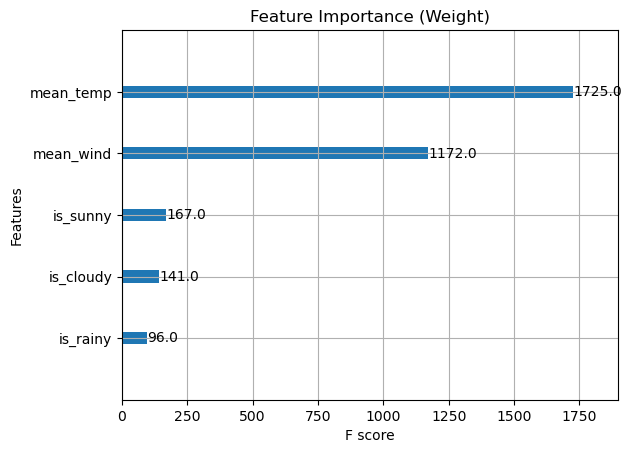

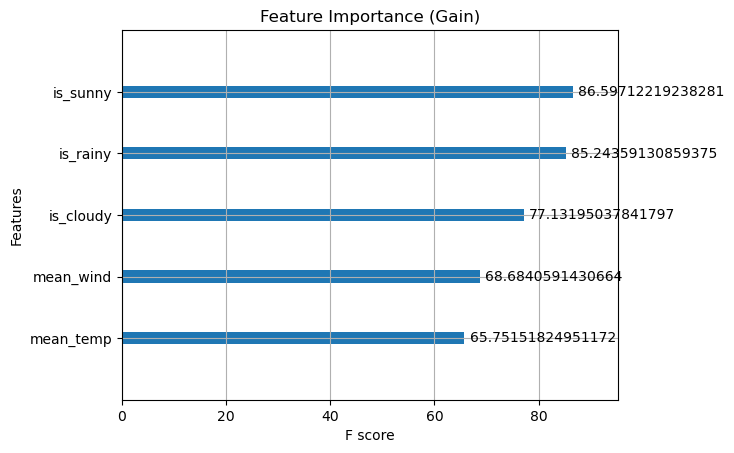

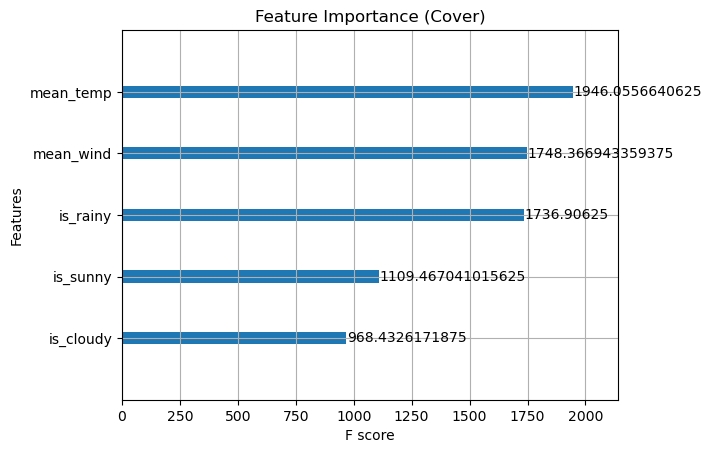

In [24]:
importance_types = ['weight', 'gain', 'cover']
for imp_type in importance_types:
    xgb.plot_importance(model, importance_type=imp_type, max_num_features=10)
    plt.title(f'Feature Importance ({imp_type.capitalize()})')
    plt.show()


And let us see the actual tree and how it determined its splits

<Figure size 6000x4500 with 0 Axes>

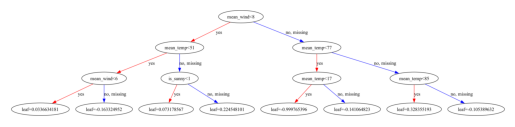

In [25]:
from xgboost import plot_tree

plt.figure(figsize=(20, 15), dpi=300) 

plot_tree(model, num_trees=0)

plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  

plt.show()


And now let's do some K-fold cross validations and plot the learning curve

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        10.609732        0.023335       10.630723       0.091860
1        10.590544        0.024759       10.626562       0.095714
2        10.576884        0.025091       10.622937       0.093339
3        10.563027        0.025346       10.622774       0.096496
4        10.552044        0.025368       10.618095       0.097012
5        10.539317        0.026871       10.617913       0.097047
6        10.529580        0.026604       10.617891       0.097674
7        10.521104        0.026987       10.616816       0.098809


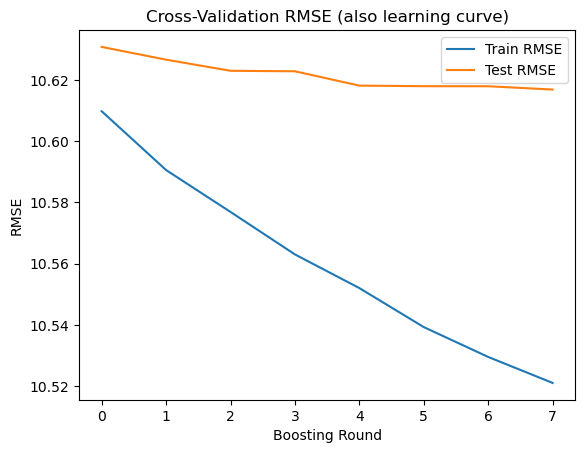

In [28]:
dtrain = xgb.DMatrix(data=train_features, label=train_label)
params = {
    'max_depth': 3,
    'eta': 0.14,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

cv_results = xgb.cv(params, dtrain, num_boost_round=500, nfold=5, early_stopping_rounds=10, seed=42)
print(cv_results)

plt.plot(cv_results['train-rmse-mean'], label='Train RMSE')
plt.plot(cv_results['test-rmse-mean'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.title('Cross-Validation RMSE (also learning curve)')
plt.show()


Residual analysis within the test dataset next. A residual is observed - predicted.

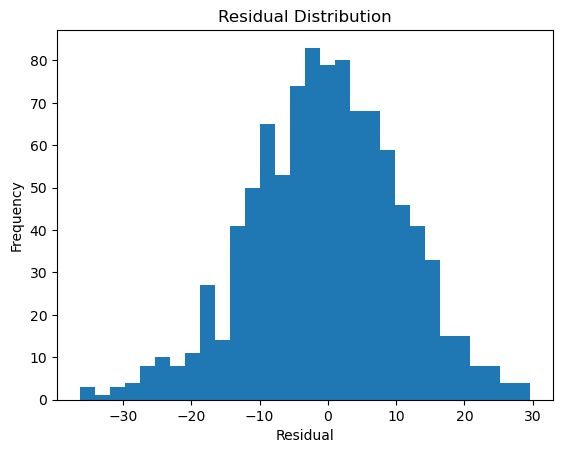

In [30]:
residuals = test_with_predictions['sum_epa'] - test_with_predictions['predicted_values']
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

In [31]:
mean_residual = residuals.mean()
print(f"Mean Residual (Bias Estimate): {mean_residual}")


Mean Residual (Bias Estimate): -0.3393363221757691


Follows an approximately normal distribution which is a good sign. Next lets look at our mean absolute error, mean squared error, and root mean squared error.

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_with_predictions['sum_epa'], test_with_predictions['predicted_values'])
mse = mean_squared_error(test_with_predictions['sum_epa'], test_with_predictions['predicted_values'])
rmse = mean_squared_error(test_with_predictions['sum_epa'], test_with_predictions['predicted_values'], squared=False)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 8.702154359782654
MSE: 121.46764526604359
RMSE: 11.021236104269049


Next, let's compare the predicted values to the observed values.

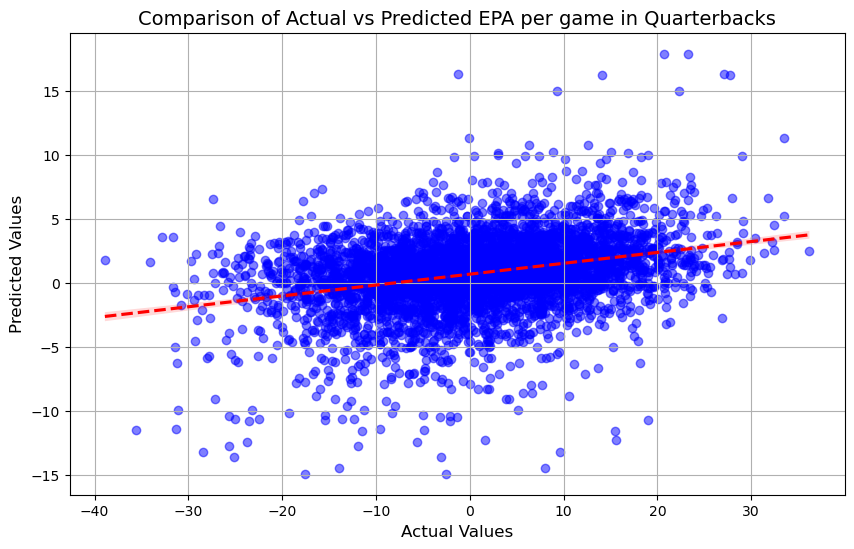

In [35]:

plt.figure(figsize=(10, 6))  

sns.regplot(x=predictions["sum_epa"], y=predictions["predicted_values"], scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red', 'linestyle': '--'})

plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Comparison of Actual vs Predicted EPA per game in Quarterbacks', fontsize=14)

plt.grid(True)
plt.show()

Obviously a lot of noise, but we can still see a positive association which is a good sign. This is it for this script. The next script will talk about potential applications. Let's export the final dataset.

In [36]:
predictions.to_csv("predictions.csv")